## Markov Regime Switching model


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import plt

In [2]:
np.random.seed(123)

In [3]:
def rng(time_steps):
    rn = np.random.standard_normal((time_steps, 1))
    rn -= rn.mean()
    rn /= rn.std()
    return rn

In [4]:
def mrs_model(time_steps=500, W=[.118, .286]):
    eps1 = rng(time_steps) * .816
    eps2 = rng(time_steps) * 1.07
    y = np.zeros(time_steps)
    s = np.zeros(time_steps, dtype=int)
    ru = np.random.uniform(size=time_steps)
    for i in range(1, time_steps):
        if(s[i-1]==0 and ru[i] > W[0]) or (s[i-1]==1 and ru[i] <= W[0]):
            s[i] = 0
            y[i] = .909 + .265*y[i-1] + .029*y[i-2] - .126*y[i-3] - .110*y[i-4] + eps1[i]
        else:
            s[i] = 1
            y[i] = -.420 + .216*y[i-1] + .628*y[i-2] - .073*y[i-3] - .097*y[i-4] + eps2[i]
    return y, s

In [5]:
y, s = mrs_model(time_steps=500, W=[.118, .286])

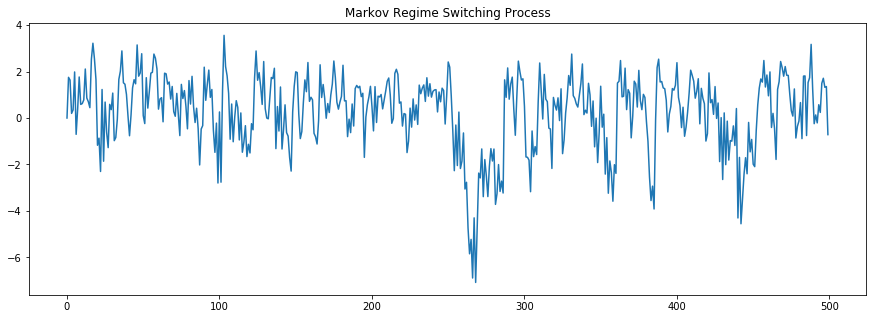

In [6]:
plt.figure(figsize=(15,5))
plt.title('Markov Regime Switching Process')
plt.plot(y);

In [7]:
df = pd.DataFrame(y, columns=['mrs_model'], index=range(500))

In [8]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['mrs_model'].shift(lag)

df = df.dropna(how='any')

In [9]:
Y = df[['mrs_model']].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [10]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

In [12]:
ols_results = pd.DataFrame(y, columns=['model'])
ols_results['in_sample'] = np.nan
ols_results['out_sample'] = np.nan
ols_in_sample = results.fittedvalues.flatten()
ols_out_sample = results.predict(test_X)

ols_results.loc[5:400, 'in_sample'] = results.fittedvalues.flatten()
ols_results.loc[400:, 'out_sample'] = results.predict(test_X)

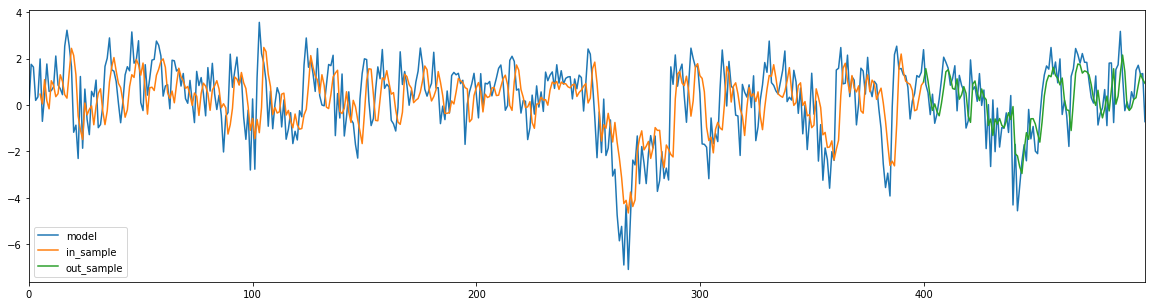

In [13]:
ols_results.plot(figsize=(20, 5));

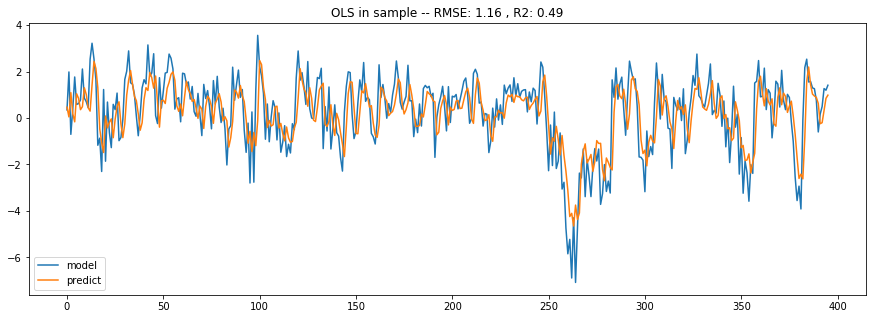

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(ols_in_sample, label='predict')
# calculate root mean squared error
ols_train_rmse = np.sqrt(mean_squared_error(train_Y.flatten(), ols_in_sample))
plt.title('OLS in sample -- RMSE: %.2f , R2: %.2f' % (ols_train_rmse, r2_score(train_Y.flatten(), ols_in_sample)))
plt.legend(loc=0)
plt.show()

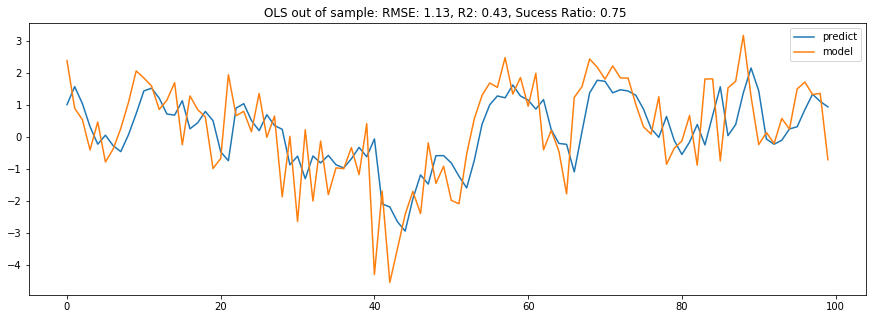

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(ols_out_sample, label='predict')
plt.plot(test_Y, label='model')
# calculate root mean squared error
ols_test_rmse = np.sqrt(mean_squared_error(test_Y.flatten(), ols_out_sample))
# Success ratio
sr = np.mean(np.sign(ols_out_sample)==np.sign(test_Y.flatten()))
plt.title('OLS out of sample: RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (ols_test_rmse, r2_score(test_Y.flatten(), ols_out_sample), sr))
plt.legend(loc=0)
plt.show()

## Deep Learning with Keras

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [17]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [18]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [19]:
model = Sequential()
model.add(Dense(3, input_dim=lags))
model.add(LeakyReLU())
model.add(Dense(1))
#model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam', metrics=[success_ratio, r_coeff])

In [20]:
history = model.fit(train_X, train_Y, 
                    epochs=6000, 
                    batch_size=len(train_X), 
                    verbose=2,
                    validation_data=(test_X, test_Y), 
                    shuffle=False, 
                   )

Train on 396 samples, validate on 100 samples
Epoch 1/6000
0s - loss: 5.9908 - success_ratio: 0.3535 - r_coeff: -1.2494e+00 - val_loss: 5.1508 - val_success_ratio: 0.3400 - val_r_coeff: -1.2699e+00
Epoch 2/6000
0s - loss: 5.9397 - success_ratio: 0.3586 - r_coeff: -1.2302e+00 - val_loss: 5.1079 - val_success_ratio: 0.3400 - val_r_coeff: -1.2510e+00
Epoch 3/6000
0s - loss: 5.8889 - success_ratio: 0.3586 - r_coeff: -1.2111e+00 - val_loss: 5.0652 - val_success_ratio: 0.3400 - val_r_coeff: -1.2322e+00
Epoch 4/6000
0s - loss: 5.8385 - success_ratio: 0.3586 - r_coeff: -1.1922e+00 - val_loss: 5.0229 - val_success_ratio: 0.3400 - val_r_coeff: -1.2136e+00
Epoch 5/6000
0s - loss: 5.7884 - success_ratio: 0.3586 - r_coeff: -1.1734e+00 - val_loss: 4.9808 - val_success_ratio: 0.3400 - val_r_coeff: -1.1950e+00
Epoch 6/6000
0s - loss: 5.7388 - success_ratio: 0.3586 - r_coeff: -1.1547e+00 - val_loss: 4.9391 - val_success_ratio: 0.3400 - val_r_coeff: -1.1767e+00
Epoch 7/6000
0s - loss: 5.6895 - success_r

Epoch 197/6000
0s - loss: 1.6837 - success_ratio: 0.7071 - r_coeff: 0.3678 - val_loss: 1.5174 - val_success_ratio: 0.6900 - val_r_coeff: 0.3313
Epoch 198/6000
0s - loss: 1.6796 - success_ratio: 0.7071 - r_coeff: 0.3694 - val_loss: 1.5135 - val_success_ratio: 0.6900 - val_r_coeff: 0.3330
Epoch 199/6000
0s - loss: 1.6756 - success_ratio: 0.7045 - r_coeff: 0.3709 - val_loss: 1.5097 - val_success_ratio: 0.6900 - val_r_coeff: 0.3347
Epoch 200/6000
0s - loss: 1.6717 - success_ratio: 0.7045 - r_coeff: 0.3723 - val_loss: 1.5059 - val_success_ratio: 0.7100 - val_r_coeff: 0.3364
Epoch 201/6000
0s - loss: 1.6678 - success_ratio: 0.7071 - r_coeff: 0.3738 - val_loss: 1.5022 - val_success_ratio: 0.7200 - val_r_coeff: 0.3380
Epoch 202/6000
0s - loss: 1.6640 - success_ratio: 0.7121 - r_coeff: 0.3752 - val_loss: 1.4986 - val_success_ratio: 0.7200 - val_r_coeff: 0.3396
Epoch 203/6000
0s - loss: 1.6603 - success_ratio: 0.7146 - r_coeff: 0.3766 - val_loss: 1.4950 - val_success_ratio: 0.7200 - val_r_coeff:

0s - loss: 1.4317 - success_ratio: 0.7576 - r_coeff: 0.4624 - val_loss: 1.2853 - val_success_ratio: 0.7400 - val_r_coeff: 0.4336
Epoch 364/6000
0s - loss: 1.4312 - success_ratio: 0.7576 - r_coeff: 0.4626 - val_loss: 1.2850 - val_success_ratio: 0.7500 - val_r_coeff: 0.4337
Epoch 365/6000
0s - loss: 1.4307 - success_ratio: 0.7576 - r_coeff: 0.4628 - val_loss: 1.2847 - val_success_ratio: 0.7500 - val_r_coeff: 0.4338
Epoch 366/6000
0s - loss: 1.4301 - success_ratio: 0.7576 - r_coeff: 0.4630 - val_loss: 1.2844 - val_success_ratio: 0.7500 - val_r_coeff: 0.4340
Epoch 367/6000
0s - loss: 1.4296 - success_ratio: 0.7576 - r_coeff: 0.4632 - val_loss: 1.2840 - val_success_ratio: 0.7500 - val_r_coeff: 0.4341
Epoch 368/6000
0s - loss: 1.4291 - success_ratio: 0.7576 - r_coeff: 0.4634 - val_loss: 1.2837 - val_success_ratio: 0.7500 - val_r_coeff: 0.4343
Epoch 369/6000
0s - loss: 1.4285 - success_ratio: 0.7576 - r_coeff: 0.4636 - val_loss: 1.2834 - val_success_ratio: 0.7500 - val_r_coeff: 0.4344
Epoch 3

0s - loss: 1.3762 - success_ratio: 0.7626 - r_coeff: 0.4833 - val_loss: 1.2632 - val_success_ratio: 0.7200 - val_r_coeff: 0.4433
Epoch 506/6000
0s - loss: 1.3759 - success_ratio: 0.7626 - r_coeff: 0.4834 - val_loss: 1.2632 - val_success_ratio: 0.7200 - val_r_coeff: 0.4433
Epoch 507/6000
0s - loss: 1.3756 - success_ratio: 0.7626 - r_coeff: 0.4835 - val_loss: 1.2631 - val_success_ratio: 0.7200 - val_r_coeff: 0.4433
Epoch 508/6000
0s - loss: 1.3754 - success_ratio: 0.7626 - r_coeff: 0.4836 - val_loss: 1.2631 - val_success_ratio: 0.7200 - val_r_coeff: 0.4434
Epoch 509/6000
0s - loss: 1.3751 - success_ratio: 0.7626 - r_coeff: 0.4837 - val_loss: 1.2630 - val_success_ratio: 0.7300 - val_r_coeff: 0.4434
Epoch 510/6000
0s - loss: 1.3748 - success_ratio: 0.7626 - r_coeff: 0.4838 - val_loss: 1.2630 - val_success_ratio: 0.7300 - val_r_coeff: 0.4434
Epoch 511/6000
0s - loss: 1.3745 - success_ratio: 0.7626 - r_coeff: 0.4839 - val_loss: 1.2630 - val_success_ratio: 0.7300 - val_r_coeff: 0.4434
Epoch 5

0s - loss: 1.3410 - success_ratio: 0.7727 - r_coeff: 0.4965 - val_loss: 1.2677 - val_success_ratio: 0.7400 - val_r_coeff: 0.4413
Epoch 672/6000
0s - loss: 1.3409 - success_ratio: 0.7727 - r_coeff: 0.4966 - val_loss: 1.2677 - val_success_ratio: 0.7400 - val_r_coeff: 0.4413
Epoch 673/6000
0s - loss: 1.3407 - success_ratio: 0.7727 - r_coeff: 0.4966 - val_loss: 1.2678 - val_success_ratio: 0.7400 - val_r_coeff: 0.4413
Epoch 674/6000
0s - loss: 1.3406 - success_ratio: 0.7727 - r_coeff: 0.4967 - val_loss: 1.2678 - val_success_ratio: 0.7400 - val_r_coeff: 0.4413
Epoch 675/6000
0s - loss: 1.3404 - success_ratio: 0.7727 - r_coeff: 0.4967 - val_loss: 1.2679 - val_success_ratio: 0.7400 - val_r_coeff: 0.4412
Epoch 676/6000
0s - loss: 1.3403 - success_ratio: 0.7727 - r_coeff: 0.4968 - val_loss: 1.2680 - val_success_ratio: 0.7400 - val_r_coeff: 0.4412
Epoch 677/6000
0s - loss: 1.3402 - success_ratio: 0.7727 - r_coeff: 0.4968 - val_loss: 1.2680 - val_success_ratio: 0.7400 - val_r_coeff: 0.4412
Epoch 6

0s - loss: 1.3226 - success_ratio: 0.7677 - r_coeff: 0.5034 - val_loss: 1.2825 - val_success_ratio: 0.7400 - val_r_coeff: 0.4348
Epoch 856/6000
0s - loss: 1.3225 - success_ratio: 0.7677 - r_coeff: 0.5034 - val_loss: 1.2826 - val_success_ratio: 0.7400 - val_r_coeff: 0.4348
Epoch 857/6000
0s - loss: 1.3224 - success_ratio: 0.7677 - r_coeff: 0.5035 - val_loss: 1.2827 - val_success_ratio: 0.7400 - val_r_coeff: 0.4347
Epoch 858/6000
0s - loss: 1.3224 - success_ratio: 0.7677 - r_coeff: 0.5035 - val_loss: 1.2828 - val_success_ratio: 0.7400 - val_r_coeff: 0.4347
Epoch 859/6000
0s - loss: 1.3223 - success_ratio: 0.7677 - r_coeff: 0.5035 - val_loss: 1.2829 - val_success_ratio: 0.7400 - val_r_coeff: 0.4346
Epoch 860/6000
0s - loss: 1.3222 - success_ratio: 0.7677 - r_coeff: 0.5035 - val_loss: 1.2829 - val_success_ratio: 0.7400 - val_r_coeff: 0.4346
Epoch 861/6000
0s - loss: 1.3222 - success_ratio: 0.7677 - r_coeff: 0.5036 - val_loss: 1.2830 - val_success_ratio: 0.7400 - val_r_coeff: 0.4346
Epoch 8

0s - loss: 1.3141 - success_ratio: 0.7753 - r_coeff: 0.5066 - val_loss: 1.2970 - val_success_ratio: 0.7400 - val_r_coeff: 0.4284
Epoch 1038/6000
0s - loss: 1.3141 - success_ratio: 0.7753 - r_coeff: 0.5066 - val_loss: 1.2970 - val_success_ratio: 0.7400 - val_r_coeff: 0.4284
Epoch 1039/6000
0s - loss: 1.3140 - success_ratio: 0.7753 - r_coeff: 0.5066 - val_loss: 1.2971 - val_success_ratio: 0.7400 - val_r_coeff: 0.4284
Epoch 1040/6000
0s - loss: 1.3140 - success_ratio: 0.7753 - r_coeff: 0.5066 - val_loss: 1.2972 - val_success_ratio: 0.7400 - val_r_coeff: 0.4283
Epoch 1041/6000
0s - loss: 1.3140 - success_ratio: 0.7753 - r_coeff: 0.5067 - val_loss: 1.2972 - val_success_ratio: 0.7400 - val_r_coeff: 0.4283
Epoch 1042/6000
0s - loss: 1.3139 - success_ratio: 0.7753 - r_coeff: 0.5067 - val_loss: 1.2973 - val_success_ratio: 0.7400 - val_r_coeff: 0.4283
Epoch 1043/6000
0s - loss: 1.3139 - success_ratio: 0.7753 - r_coeff: 0.5067 - val_loss: 1.2974 - val_success_ratio: 0.7400 - val_r_coeff: 0.4282
E

0s - loss: 1.3092 - success_ratio: 0.7753 - r_coeff: 0.5084 - val_loss: 1.3050 - val_success_ratio: 0.7400 - val_r_coeff: 0.4249
Epoch 1190/6000
0s - loss: 1.3092 - success_ratio: 0.7753 - r_coeff: 0.5084 - val_loss: 1.3051 - val_success_ratio: 0.7400 - val_r_coeff: 0.4249
Epoch 1191/6000
0s - loss: 1.3092 - success_ratio: 0.7753 - r_coeff: 0.5084 - val_loss: 1.3051 - val_success_ratio: 0.7400 - val_r_coeff: 0.4249
Epoch 1192/6000
0s - loss: 1.3092 - success_ratio: 0.7753 - r_coeff: 0.5085 - val_loss: 1.3051 - val_success_ratio: 0.7400 - val_r_coeff: 0.4248
Epoch 1193/6000
0s - loss: 1.3091 - success_ratio: 0.7753 - r_coeff: 0.5085 - val_loss: 1.3052 - val_success_ratio: 0.7400 - val_r_coeff: 0.4248
Epoch 1194/6000
0s - loss: 1.3091 - success_ratio: 0.7753 - r_coeff: 0.5085 - val_loss: 1.3052 - val_success_ratio: 0.7400 - val_r_coeff: 0.4248
Epoch 1195/6000
0s - loss: 1.3091 - success_ratio: 0.7753 - r_coeff: 0.5085 - val_loss: 1.3052 - val_success_ratio: 0.7400 - val_r_coeff: 0.4248
E

0s - loss: 1.3061 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3089 - val_success_ratio: 0.7400 - val_r_coeff: 0.4232
Epoch 1328/6000
0s - loss: 1.3061 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3089 - val_success_ratio: 0.7400 - val_r_coeff: 0.4232
Epoch 1329/6000
0s - loss: 1.3061 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3089 - val_success_ratio: 0.7400 - val_r_coeff: 0.4232
Epoch 1330/6000
0s - loss: 1.3061 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3089 - val_success_ratio: 0.7400 - val_r_coeff: 0.4232
Epoch 1331/6000
0s - loss: 1.3060 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 1332/6000
0s - loss: 1.3060 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 1333/6000
0s - loss: 1.3060 - success_ratio: 0.7753 - r_coeff: 0.5096 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
E

0s - loss: 1.3030 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1511/6000
0s - loss: 1.3030 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1512/6000
0s - loss: 1.3029 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1513/6000
0s - loss: 1.3029 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1514/6000
0s - loss: 1.3029 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1515/6000
0s - loss: 1.3029 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4218
Epoch 1516/6000
0s - loss: 1.3029 - success_ratio: 0.7727 - r_coeff: 0.5108 - val_loss: 1.3121 - val_success_ratio: 0.7400 - val_r_coeff: 0.4217
E

Epoch 1619/6000
0s - loss: 1.3014 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1620/6000
0s - loss: 1.3014 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1621/6000
0s - loss: 1.3013 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1622/6000
0s - loss: 1.3013 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1623/6000
0s - loss: 1.3013 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1624/6000
0s - loss: 1.3013 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
Epoch 1625/6000
0s - loss: 1.3013 - success_ratio: 0.7753 - r_coeff: 0.5114 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r

Epoch 1773/6000
0s - loss: 1.2993 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 1774/6000
0s - loss: 1.2993 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 1775/6000
0s - loss: 1.2992 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 1776/6000
0s - loss: 1.2992 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 1777/6000
0s - loss: 1.2992 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 1778/6000
0s - loss: 1.2992 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4212
Epoch 1779/6000
0s - loss: 1.2992 - success_ratio: 0.7727 - r_coeff: 0.5122 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r

Epoch 1934/6000
0s - loss: 1.2970 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1935/6000
0s - loss: 1.2970 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1936/6000
0s - loss: 1.2970 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1937/6000
0s - loss: 1.2970 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1938/6000
0s - loss: 1.2970 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1939/6000
0s - loss: 1.2969 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r_coeff: 0.4203
Epoch 1940/6000
0s - loss: 1.2969 - success_ratio: 0.7727 - r_coeff: 0.5130 - val_loss: 1.3155 - val_success_ratio: 0.7400 - val_r

Epoch 2094/6000
0s - loss: 1.2951 - success_ratio: 0.7753 - r_coeff: 0.5137 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2095/6000
0s - loss: 1.2951 - success_ratio: 0.7753 - r_coeff: 0.5137 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2096/6000
0s - loss: 1.2950 - success_ratio: 0.7753 - r_coeff: 0.5138 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2097/6000
0s - loss: 1.2950 - success_ratio: 0.7753 - r_coeff: 0.5138 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2098/6000
0s - loss: 1.2950 - success_ratio: 0.7753 - r_coeff: 0.5138 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2099/6000
0s - loss: 1.2950 - success_ratio: 0.7753 - r_coeff: 0.5138 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r_coeff: 0.4202
Epoch 2100/6000
0s - loss: 1.2950 - success_ratio: 0.7753 - r_coeff: 0.5138 - val_loss: 1.3156 - val_success_ratio: 0.7400 - val_r

Epoch 2197/6000
0s - loss: 1.2934 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2198/6000
0s - loss: 1.2934 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2199/6000
0s - loss: 1.2934 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2200/6000
0s - loss: 1.2933 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2201/6000
0s - loss: 1.2933 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2202/6000
0s - loss: 1.2933 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r_coeff: 0.4201
Epoch 2203/6000
0s - loss: 1.2933 - success_ratio: 0.7753 - r_coeff: 0.5144 - val_loss: 1.3158 - val_success_ratio: 0.7400 - val_r

0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3177 - val_success_ratio: 0.7400 - val_r_coeff: 0.4193
Epoch 2345/6000
0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4193
Epoch 2346/6000
0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4193
Epoch 2347/6000
0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4193
Epoch 2348/6000
0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4193
Epoch 2349/6000
0s - loss: 1.2909 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4192
Epoch 2350/6000
0s - loss: 1.2908 - success_ratio: 0.7753 - r_coeff: 0.5153 - val_loss: 1.3178 - val_success_ratio: 0.7400 - val_r_coeff: 0.4192
E

0s - loss: 1.2892 - success_ratio: 0.7727 - r_coeff: 0.5159 - val_loss: 1.3191 - val_success_ratio: 0.7400 - val_r_coeff: 0.4187
Epoch 2465/6000
0s - loss: 1.2892 - success_ratio: 0.7727 - r_coeff: 0.5159 - val_loss: 1.3191 - val_success_ratio: 0.7400 - val_r_coeff: 0.4187
Epoch 2466/6000
0s - loss: 1.2892 - success_ratio: 0.7727 - r_coeff: 0.5160 - val_loss: 1.3192 - val_success_ratio: 0.7400 - val_r_coeff: 0.4186
Epoch 2467/6000
0s - loss: 1.2892 - success_ratio: 0.7727 - r_coeff: 0.5160 - val_loss: 1.3192 - val_success_ratio: 0.7400 - val_r_coeff: 0.4186
Epoch 2468/6000
0s - loss: 1.2891 - success_ratio: 0.7727 - r_coeff: 0.5160 - val_loss: 1.3193 - val_success_ratio: 0.7400 - val_r_coeff: 0.4186
Epoch 2469/6000
0s - loss: 1.2891 - success_ratio: 0.7727 - r_coeff: 0.5160 - val_loss: 1.3193 - val_success_ratio: 0.7400 - val_r_coeff: 0.4186
Epoch 2470/6000
0s - loss: 1.2891 - success_ratio: 0.7727 - r_coeff: 0.5160 - val_loss: 1.3194 - val_success_ratio: 0.7400 - val_r_coeff: 0.4186
E

0s - loss: 1.2861 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3204 - val_success_ratio: 0.7400 - val_r_coeff: 0.4181
Epoch 2565/6000
0s - loss: 1.2861 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3203 - val_success_ratio: 0.7400 - val_r_coeff: 0.4181
Epoch 2566/6000
0s - loss: 1.2861 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3203 - val_success_ratio: 0.7400 - val_r_coeff: 0.4181
Epoch 2567/6000
0s - loss: 1.2861 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3203 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 2568/6000
0s - loss: 1.2860 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 2569/6000
0s - loss: 1.2860 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 2570/6000
0s - loss: 1.2860 - success_ratio: 0.7727 - r_coeff: 0.5171 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
E

0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5179 - val_loss: 1.3183 - val_success_ratio: 0.7400 - val_r_coeff: 0.4190
Epoch 2702/6000
0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5179 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 2703/6000
0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5179 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 2704/6000
0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5179 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 2705/6000
0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5179 - val_loss: 1.3181 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 2706/6000
0s - loss: 1.2839 - success_ratio: 0.7727 - r_coeff: 0.5180 - val_loss: 1.3181 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 2707/6000
0s - loss: 1.2838 - success_ratio: 0.7727 - r_coeff: 0.5180 - val_loss: 1.3181 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
E

0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3137 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2832/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3137 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2833/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3136 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2834/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3136 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2835/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3136 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2836/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3135 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
Epoch 2837/6000
0s - loss: 1.2818 - success_ratio: 0.7702 - r_coeff: 0.5187 - val_loss: 1.3135 - val_success_ratio: 0.7400 - val_r_coeff: 0.4211
E

0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2966/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2967/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2968/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2969/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2970/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3119 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
Epoch 2971/6000
0s - loss: 1.2803 - success_ratio: 0.7702 - r_coeff: 0.5193 - val_loss: 1.3118 - val_success_ratio: 0.7400 - val_r_coeff: 0.4219
E

0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3141/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3142/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3143/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3144/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3145/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3146/6000
0s - loss: 1.2789 - success_ratio: 0.7702 - r_coeff: 0.5198 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
E

0s - loss: 1.2780 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3285/6000
0s - loss: 1.2780 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3286/6000
0s - loss: 1.2779 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3287/6000
0s - loss: 1.2779 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3288/6000
0s - loss: 1.2779 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3091 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3289/6000
0s - loss: 1.2779 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3290/6000
0s - loss: 1.2779 - success_ratio: 0.7677 - r_coeff: 0.5202 - val_loss: 1.3090 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
E

0s - loss: 1.2769 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3401/6000
0s - loss: 1.2769 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3402/6000
0s - loss: 1.2769 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3403/6000
0s - loss: 1.2768 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4231
Epoch 3404/6000
0s - loss: 1.2768 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4230
Epoch 3405/6000
0s - loss: 1.2768 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3092 - val_success_ratio: 0.7400 - val_r_coeff: 0.4230
Epoch 3406/6000
0s - loss: 1.2768 - success_ratio: 0.7677 - r_coeff: 0.5206 - val_loss: 1.3093 - val_success_ratio: 0.7400 - val_r_coeff: 0.4230
E

Epoch 3536/6000
0s - loss: 1.2753 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3537/6000
0s - loss: 1.2753 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3538/6000
0s - loss: 1.2753 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3539/6000
0s - loss: 1.2753 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3540/6000
0s - loss: 1.2753 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3541/6000
0s - loss: 1.2752 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r_coeff: 0.4233
Epoch 3542/6000
0s - loss: 1.2752 - success_ratio: 0.7727 - r_coeff: 0.5212 - val_loss: 1.3085 - val_success_ratio: 0.7400 - val_r

Epoch 3651/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3652/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3653/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3654/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3655/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3656/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 3657/6000
0s - loss: 1.2734 - success_ratio: 0.7753 - r_coeff: 0.5219 - val_loss: 1.3065 - val_success_ratio: 0.7400 - val_r

Epoch 3812/6000
0s - loss: 1.2708 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3108 - val_success_ratio: 0.7400 - val_r_coeff: 0.4223
Epoch 3813/6000
0s - loss: 1.2708 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3109 - val_success_ratio: 0.7400 - val_r_coeff: 0.4223
Epoch 3814/6000
0s - loss: 1.2708 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3109 - val_success_ratio: 0.7400 - val_r_coeff: 0.4223
Epoch 3815/6000
0s - loss: 1.2707 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3110 - val_success_ratio: 0.7400 - val_r_coeff: 0.4222
Epoch 3816/6000
0s - loss: 1.2707 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3111 - val_success_ratio: 0.7400 - val_r_coeff: 0.4222
Epoch 3817/6000
0s - loss: 1.2707 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3112 - val_success_ratio: 0.7400 - val_r_coeff: 0.4222
Epoch 3818/6000
0s - loss: 1.2707 - success_ratio: 0.7778 - r_coeff: 0.5229 - val_loss: 1.3113 - val_success_ratio: 0.7400 - val_r

0s - loss: 1.2667 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3171 - val_success_ratio: 0.7300 - val_r_coeff: 0.4196
Epoch 3993/6000
0s - loss: 1.2667 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3171 - val_success_ratio: 0.7300 - val_r_coeff: 0.4196
Epoch 3994/6000
0s - loss: 1.2667 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3171 - val_success_ratio: 0.7300 - val_r_coeff: 0.4196
Epoch 3995/6000
0s - loss: 1.2667 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3171 - val_success_ratio: 0.7300 - val_r_coeff: 0.4195
Epoch 3996/6000
0s - loss: 1.2666 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3172 - val_success_ratio: 0.7300 - val_r_coeff: 0.4195
Epoch 3997/6000
0s - loss: 1.2666 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3172 - val_success_ratio: 0.7300 - val_r_coeff: 0.4195
Epoch 3998/6000
0s - loss: 1.2666 - success_ratio: 0.7854 - r_coeff: 0.5244 - val_loss: 1.3173 - val_success_ratio: 0.7300 - val_r_coeff: 0.4195
E

0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5251 - val_loss: 1.3211 - val_success_ratio: 0.7300 - val_r_coeff: 0.4178
Epoch 4118/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5251 - val_loss: 1.3212 - val_success_ratio: 0.7300 - val_r_coeff: 0.4178
Epoch 4119/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5251 - val_loss: 1.3212 - val_success_ratio: 0.7300 - val_r_coeff: 0.4177
Epoch 4120/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5251 - val_loss: 1.3212 - val_success_ratio: 0.7300 - val_r_coeff: 0.4177
Epoch 4121/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5252 - val_loss: 1.3212 - val_success_ratio: 0.7300 - val_r_coeff: 0.4177
Epoch 4122/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5252 - val_loss: 1.3212 - val_success_ratio: 0.7300 - val_r_coeff: 0.4177
Epoch 4123/6000
0s - loss: 1.2647 - success_ratio: 0.7879 - r_coeff: 0.5252 - val_loss: 1.3213 - val_success_ratio: 0.7300 - val_r_coeff: 0.4177
E

0s - loss: 1.2621 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3234 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4256/6000
0s - loss: 1.2621 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4257/6000
0s - loss: 1.2621 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4258/6000
0s - loss: 1.2621 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4259/6000
0s - loss: 1.2621 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4260/6000
0s - loss: 1.2620 - success_ratio: 0.7854 - r_coeff: 0.5261 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
Epoch 4261/6000
0s - loss: 1.2620 - success_ratio: 0.7854 - r_coeff: 0.5262 - val_loss: 1.3233 - val_success_ratio: 0.7300 - val_r_coeff: 0.4168
E

0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4437/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4438/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4439/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4440/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4441/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
Epoch 4442/6000
0s - loss: 1.2609 - success_ratio: 0.7828 - r_coeff: 0.5266 - val_loss: 1.3200 - val_success_ratio: 0.7400 - val_r_coeff: 0.4183
E

0s - loss: 1.2598 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3203 - val_success_ratio: 0.7400 - val_r_coeff: 0.4181
Epoch 4539/6000
0s - loss: 1.2598 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3203 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 4540/6000
0s - loss: 1.2597 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 4541/6000
0s - loss: 1.2597 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 4542/6000
0s - loss: 1.2597 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 4543/6000
0s - loss: 1.2597 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
Epoch 4544/6000
0s - loss: 1.2597 - success_ratio: 0.7879 - r_coeff: 0.5270 - val_loss: 1.3202 - val_success_ratio: 0.7400 - val_r_coeff: 0.4182
E

Epoch 4640/6000
0s - loss: 1.2589 - success_ratio: 0.7879 - r_coeff: 0.5273 - val_loss: 1.3183 - val_success_ratio: 0.7400 - val_r_coeff: 0.4190
Epoch 4641/6000
0s - loss: 1.2589 - success_ratio: 0.7879 - r_coeff: 0.5273 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 4642/6000
0s - loss: 1.2589 - success_ratio: 0.7879 - r_coeff: 0.5273 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 4643/6000
0s - loss: 1.2589 - success_ratio: 0.7879 - r_coeff: 0.5273 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 4644/6000
0s - loss: 1.2589 - success_ratio: 0.7904 - r_coeff: 0.5273 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 4645/6000
0s - loss: 1.2589 - success_ratio: 0.7904 - r_coeff: 0.5273 - val_loss: 1.3182 - val_success_ratio: 0.7400 - val_r_coeff: 0.4191
Epoch 4646/6000
0s - loss: 1.2589 - success_ratio: 0.7904 - r_coeff: 0.5273 - val_loss: 1.3181 - val_success_ratio: 0.7400 - val_r

0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3132 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 4799/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4212
Epoch 4800/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3133 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 4801/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3132 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 4802/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3132 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 4803/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3131 - val_success_ratio: 0.7400 - val_r_coeff: 0.4213
Epoch 4804/6000
0s - loss: 1.2581 - success_ratio: 0.7854 - r_coeff: 0.5276 - val_loss: 1.3130 - val_success_ratio: 0.7400 - val_r_coeff: 0.4214
E

0s - loss: 1.2574 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3063 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 4975/6000
0s - loss: 1.2574 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3063 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 4976/6000
0s - loss: 1.2574 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3063 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 4977/6000
0s - loss: 1.2574 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3063 - val_success_ratio: 0.7400 - val_r_coeff: 0.4243
Epoch 4978/6000
0s - loss: 1.2573 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3062 - val_success_ratio: 0.7400 - val_r_coeff: 0.4244
Epoch 4979/6000
0s - loss: 1.2573 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3062 - val_success_ratio: 0.7400 - val_r_coeff: 0.4244
Epoch 4980/6000
0s - loss: 1.2573 - success_ratio: 0.7854 - r_coeff: 0.5279 - val_loss: 1.3062 - val_success_ratio: 0.7400 - val_r_coeff: 0.4244
E

0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5125/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5126/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5127/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5128/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5129/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
Epoch 5130/6000
0s - loss: 1.2565 - success_ratio: 0.7879 - r_coeff: 0.5282 - val_loss: 1.3047 - val_success_ratio: 0.7400 - val_r_coeff: 0.4250
E

Epoch 5264/6000
0s - loss: 1.2539 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3062 - val_success_ratio: 0.7500 - val_r_coeff: 0.4244
Epoch 5265/6000
0s - loss: 1.2539 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3062 - val_success_ratio: 0.7500 - val_r_coeff: 0.4244
Epoch 5266/6000
0s - loss: 1.2539 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3063 - val_success_ratio: 0.7500 - val_r_coeff: 0.4243
Epoch 5267/6000
0s - loss: 1.2538 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3063 - val_success_ratio: 0.7500 - val_r_coeff: 0.4243
Epoch 5268/6000
0s - loss: 1.2538 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3064 - val_success_ratio: 0.7500 - val_r_coeff: 0.4243
Epoch 5269/6000
0s - loss: 1.2538 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3064 - val_success_ratio: 0.7500 - val_r_coeff: 0.4243
Epoch 5270/6000
0s - loss: 1.2538 - success_ratio: 0.7854 - r_coeff: 0.5292 - val_loss: 1.3064 - val_success_ratio: 0.7500 - val_r

0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3050 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5443/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3050 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5444/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3051 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5445/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3051 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5446/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3051 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5447/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5304 - val_loss: 1.3051 - val_success_ratio: 0.7500 - val_r_coeff: 0.4249
Epoch 5448/6000
0s - loss: 1.2506 - success_ratio: 0.7879 - r_coeff: 0.5305 - val_loss: 1.3051 - val_success_ratio: 0.7500 - val_r_coeff: 0.4248
E

Epoch 5603/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3048 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5604/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3048 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5605/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3048 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5606/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3047 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5607/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3047 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5608/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3047 - val_success_ratio: 0.7500 - val_r_coeff: 0.4250
Epoch 5609/6000
0s - loss: 1.2493 - success_ratio: 0.7879 - r_coeff: 0.5309 - val_loss: 1.3046 - val_success_ratio: 0.7500 - val_r

0s - loss: 1.2481 - success_ratio: 0.7904 - r_coeff: 0.5314 - val_loss: 1.3030 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5754/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5755/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5756/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5757/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5758/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
Epoch 5759/6000
0s - loss: 1.2481 - success_ratio: 0.7929 - r_coeff: 0.5314 - val_loss: 1.3029 - val_success_ratio: 0.7500 - val_r_coeff: 0.4258
E

0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4267
Epoch 5917/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4267
Epoch 5918/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4267
Epoch 5919/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4267
Epoch 5920/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4266
Epoch 5921/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4266
Epoch 5922/6000
0s - loss: 1.2475 - success_ratio: 0.7980 - r_coeff: 0.5316 - val_loss: 1.3010 - val_success_ratio: 0.7500 - val_r_coeff: 0.4266
E

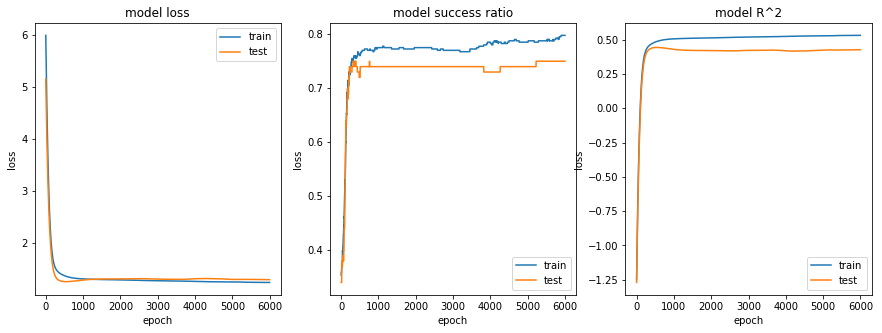

In [21]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [22]:
# make predictions
keras_in_sample = model.predict(train_X)
keras_out_sample = model.predict(test_X)

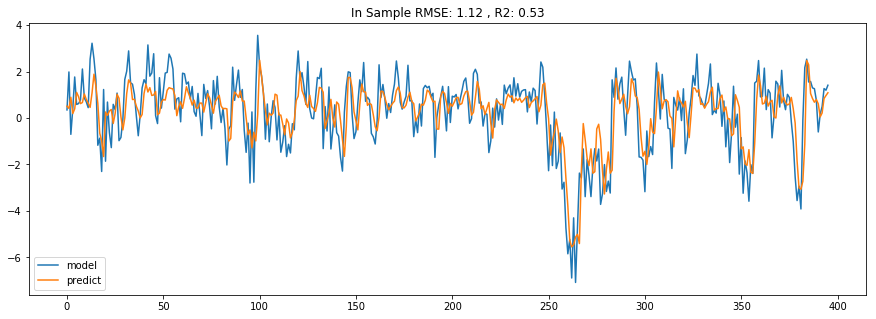

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(train_Y, keras_in_sample))
r2 = r2_score(train_Y, keras_in_sample)
plt.title('In Sample RMSE: %.2f , R2: %.2f' % (rmse, r2))
plt.legend(loc=0)
plt.show()

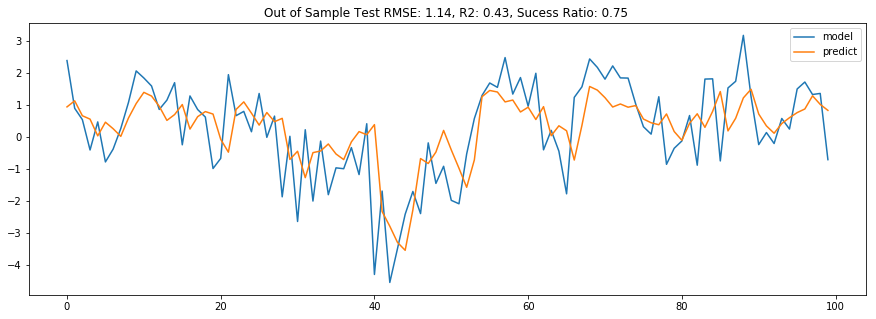

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(test_Y, keras_out_sample))
r2 = r2_score(test_Y, keras_out_sample)
# Success ratio
sr = np.mean(np.sign(keras_out_sample)==np.sign(test_Y))
plt.title('Out of Sample Test RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (rmse, r2, sr))
plt.legend(loc=0)
plt.show()